In [139]:
import numpy as np
from numpy.random import multivariate_normal as mvnrnd
import matplotlib.pyplot as plt
import control

In [140]:
# system description
np.random.seed(0)
F = mvnrnd(np.zeros(3), np.eye(3), 3).T
G = mvnrnd(np.zeros(3), np.eye(3), 3).T
H = np.random.randn(3, 1)
L = H @ np.linalg.inv(H.T @ H)
H_bar = (np.eye(3) - L @ H.T).T
Q1 = np.eye(3) * 0.01
Q2 = np.eye(1)
Q = H_bar @ Q1 @ H_bar.T + H @ Q2 @ H.T  # Q = np.eye(3)
R = np.eye(3) * 0.01

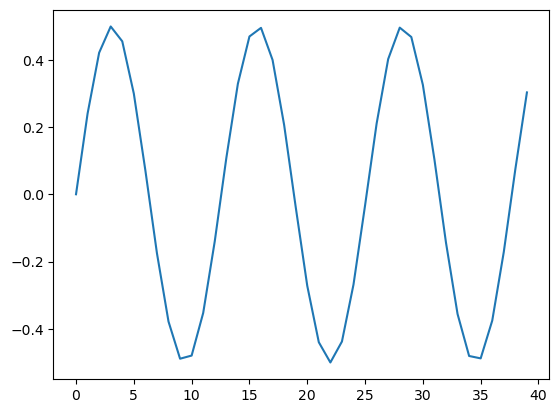

In [141]:
# target to track
T = 40
y_tilde = 0.5 * np.sin(np.arange(T) / 2)
plt.plot(y_tilde)

# desired state
x_tilde = [L @ np.array([[y_tmp]]) for y_tmp in y_tilde]

### No Control

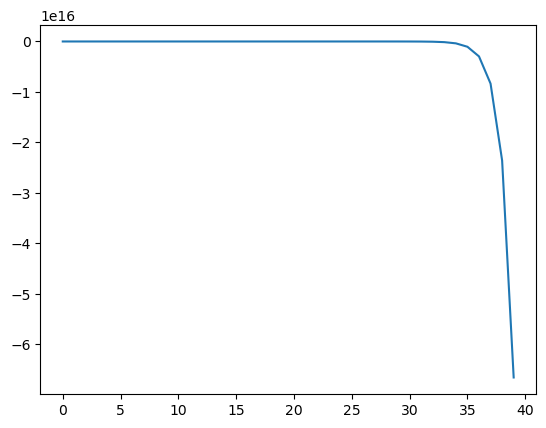

In [142]:
# initialize the state
np.random.seed(1)
x = np.random.randn(3, 1)

# without control
y_list = []
for i in range(T):
    x = F @ x
    y = H.T @ x
    y_list.append(y.item())

# plot y_list
plt.plot(y_list)

### With Control

In [143]:
# backward solve
S_list = [Q]
K_T_list = [np.zeros(shape=(3, 3))]
b_list = [np.zeros(shape=(3, 1))]
for t in np.arange(T)[-2::-1]:
    S_t1 = S_list[-1]
    b_t1 = b_list[-1]
    S_t = F.T @ (S_t1 - S_t1 @ G @ np.linalg.inv(G.T @ S_t1 @ G + R) @ G.T @ S_t1) @ F + Q
    K_T_t = -np.linalg.inv(G.T @ S_t1 @ G + R) @ G.T @ S_t1 @ F
    b_t = (F.T + K_T_t.T @ G.T) @ b_t1 - Q @ x_tilde[t]
    S_list.append(S_t)
    K_T_list.append(K_T_t)
    b_list.append(b_t)

In [144]:
# reverse S_list, K_T_list, b_list
S_list = S_list[::-1]
K_T_list = K_T_list[::-1]
b_list = b_list[::-1]

In [145]:
# initialize the state
np.random.seed(1)
x = np.random.randn(3, 1)

# with control
y_list = []
u_list = []
for i in range(T-1):
    # readout based on current state x_t
    y = H.T @ x
    # calculate u_t
    u = -np.linalg.inv(G.T @ S_list[i+1] @ G + R) @ G.T @ (S_list[i+1] @ F @ x + b_list[i+1])
    # update x_t+1
    x = F @ x + G @ u
    y_list.append(y.item())
    u_list.append(u)
# final readout for x_T
y_list.append((H.T @ x).item())

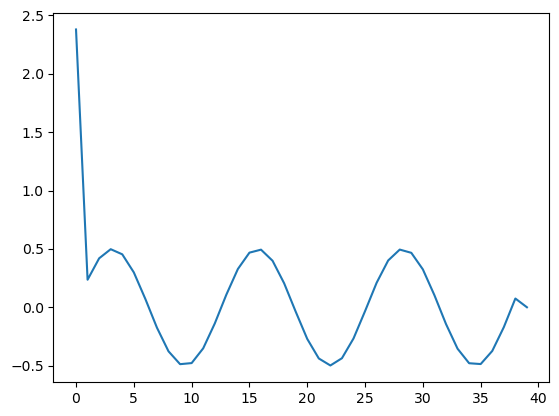

In [146]:
plt.plot(y_list)

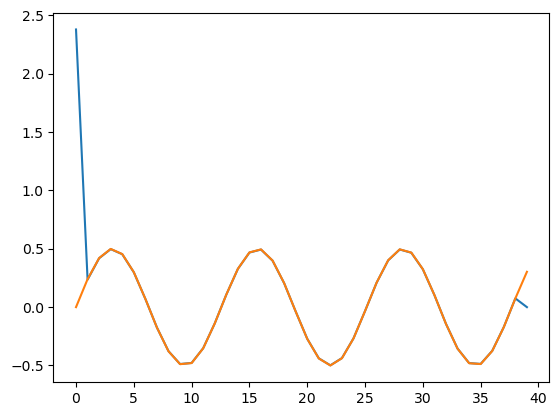

In [147]:
plt.plot(y_list)
plt.plot(y_tilde)

Mostly done! The only thing is the last time point. Why?

### T = 1?

In [160]:
# initialize the state
np.random.seed(1)
x = np.random.randn(3, 1)

# with control
y_list = []
u_list = []
for t in range(T-1):
    # readout based on current state x_t
    y = H.T @ x
    # backward solve
    S_t2 = Q
    b_t2 = np.zeros(shape=(3, 1))
    S_t1 = F.T @ (S_t2 - S_t2 @ G @ np.linalg.inv(G.T @ S_t2 @ G + R) @ G.T @ S_t2) @ F + Q
    K_T_t1 = -np.linalg.inv(G.T @ S_t2 @ G + R) @ G.T @ S_t2 @ F
    b_t1 = (F.T + K_T_t1.T @ G.T) @ b_t2 - Q @ x_tilde[t+1]
    # calculate u_t
    u = -np.linalg.inv(G.T @ S_t1 @ G + R) @ G.T @ (S_t1 @ F @ x + b_t1)  # u = -np.linalg.inv(G.T @ S_list[i+1] @ G + R) @ G.T @ (S_list[i+1] @ F @ x + b_list[i+1])
    # update x_t+1
    x = F @ x + G @ u
    y_list.append(y.item())
    u_list.append(u)
# final readout for x_T
y_list.append((H.T @ x).item())

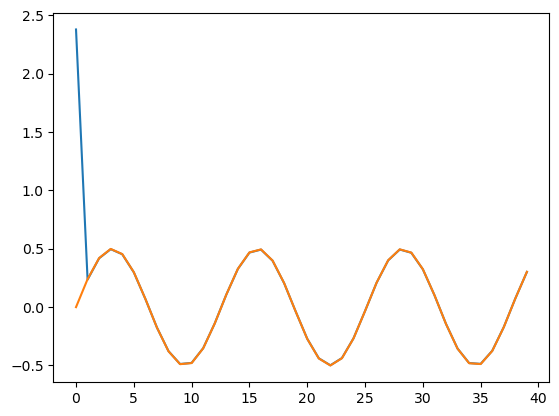

In [161]:
plt.plot(y_list)
plt.plot(y_tilde)

Very cool! Almost the same effect. Even solve the problem of the last timepoint.